In [68]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import sys, os, copy, glob


In [69]:
####diffusion barriers 0.90, 0.97, 1.00, 1.03
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

kB = 8.617333262e-5 #eV/K
###############input parameters################
temperature = 473 #######lets test 383, 413, 443, 473, and 500 K (110, 140, 170, 200, 227 C)
zpecorrection = -0.035  ###what happens when we go with -0.035? -0.0175, -0.035, 0 
prefactor = 1e13
cutoff = 3.3 ###ovito strain analysis cutoff
testname = 'test0'
randomseed = 0
np.random.seed(randomseed)
###############################################
motherdir = './{}_zpe{}_{}K'.format(testname, zpecorrection,temperature)
os.makedirs(motherdir, exist_ok=True)
print('directory to save files to: ', motherdir)

###The raw data for diffusion barriers. for 0.90, 0.97, 1.00, 1.03 lattice parameters
###As there exists mismatch between the lattice parameters of DFT and MD, we need to correct the diffusion barriers. 
###Thus we multiply the lattice strained percentage by their respective lattice parameter.
lattice_percentage = np.array([0.90, 0.97, 1.00, 1.03])
mose2_lattice_params_dft = lattice_percentage * 3.282
mose2_lattice_params_md = lattice_percentage * 3.311355309
mose2_diffusion_barrier = [0.08932034999997995, 0.11713478000001487, 0.1438839799999414,0.16479070000002594]
mos2_lattice_params_dft = lattice_percentage * 3.152
mos2_lattice_params_md = lattice_percentage * 3.117542598
mos2_diffusion_barrier = [0.09096137999995335,0.11926485000003595, 0.13165033999996467, 0.15313852999997835]

mose2_exponential_term= np.exp(-(np.array(mose2_diffusion_barrier) + zpecorrection)/(kB*temperature))
mos2_exponential_term = np.exp(-(np.array(mos2_diffusion_barrier) + zpecorrection)/(kB*temperature))

def func(x, a, b):
    return a*x + b

mose2_diffusion_barrier_zpe_corrected = np.array(mose2_diffusion_barrier) + zpecorrection
mos2_diffusion_barrier_zpe_corrected = np.array(mos2_diffusion_barrier) + zpecorrection
popt_mose, pcov_mose = curve_fit(func, mose2_lattice_params_dft, mose2_diffusion_barrier_zpe_corrected)
popt_mos, pcov_mos = curve_fit(func, mos2_lattice_params_dft, mos2_diffusion_barrier_zpe_corrected)


def get_diffusion_barrier_zped(atom_type0, atom_type1, atomic_distance, popt_mose=popt_mose, popt_mos=popt_mos):
    mosefunc = func(atomic_distance, *popt_mose)
    mosfunc = func(atomic_distance, *popt_mos)
    bothfunc =(mosefunc + mosfunc )/2

    if atom_type0 == 'Se' and atom_type1 == 'Se':
        return mosefunc
    elif atom_type0 == 'S' and atom_type1 == 'S':
        return mosfunc
    else:
        return bothfunc

def get_diffusion_barrier_zped_md(atom_type0, atom_type1, atomic_distance_md):
    Se_md_to_dft = atomic_distance_md * 3.282 /3.311355309
    S_md_to_dft = atomic_distance_md * 3.152 /3.117542598
    SeS_md_to_dft = atomic_distance_md * (3.282+3.152)/ (3.311355309+3.117542598)
    if atom_type0 == 'Se' and atom_type1 == 'Se':
        return get_diffusion_barrier_zped('Se', 'Se', Se_md_to_dft)
    elif atom_type0 == 'S' and atom_type1 == 'S':
        return get_diffusion_barrier_zped('S', 'S', S_md_to_dft)
    else:
        return get_diffusion_barrier_zped('Se', 'S', SeS_md_to_dft)
    


###now, all we have to do is extract atomic distances from the neighborlist file, and bin them to 20 bins each for Se-Se, S-S, Se-S
print(temperature, 'K')
print(zpecorrection, 'eV')
print('prefactor', prefactor)

directory to save files to:  ./test0_zpe-0.035_473K
473 K
-0.035 eV
prefactor 10000000000000.0


In [70]:
##########data for adsorption energy#################################################

###we first need to get xx,yy, zz strain tensor average data of the optimized structures
atomic_strains = pd.read_csv('./planar55_xxyyzz.csv') ###this file contains

###we now get the TMA adsorption energy data precomputed using ASE thermochemistry module, for temperatures of interest
adsenergies = pd.read_csv('./gibbs_free_energies_ver-hinderedthermo_kp331_2pa.csv')

###extract the row name from adsenergies and make it a column
df_thermo_strain = pd.merge(atomic_strains, adsenergies, on='casename')

In [72]:
def func_linear(x, a, b):
    return a * x + b

# def func_quadratic(x, a, b, c):
#     return a * x**2 + b * x + c

# def func_quadratic_negative_a(x, a, b, c):
#     return -abs(a) * x**2 + b * x + c

# def func_tri(x, a, b, c, d):
#     return a * x**3 + b * x**2 + c * x + d

def get_adsorption_energy(atom_type, atomic_strain, func, temperature=500):
    """
    inputs adsorption site's description.
    atom_type: Se or S
    atomic_strain: strain of the adsorption site
    func: function to fit the strain to adsorption energy
    temperature: temperature of the system. can be 300, 383, 413, 443, 473, 500 K from the df. (110, 140, 170, 200, 227 C)
    outputs gibbs free energy of adsorption at certain temperature
    
    since we only calculate four points, we will use linear interpolation from point A to point B, B to C.
    """

    # Fitting data 
    mose2_atomic_strains = df_thermo_strain[df_thermo_strain['casename'].str.contains('mose55')]['strain']
    mose2_adsenergies = df_thermo_strain[df_thermo_strain['casename'].str.contains('mose55')][str(temperature)]
    mos2_atomic_strains = df_thermo_strain[df_thermo_strain['casename'].str.contains('mos55')]['strain']
    mos2_adsenergies = df_thermo_strain[df_thermo_strain['casename'].str.contains('mos55')][str(temperature)]

    popt_mose, pcov_mose = curve_fit(func, mose2_atomic_strains, mose2_adsenergies)
    popt_mos, pcov_mos = curve_fit(func, mos2_atomic_strains, mos2_adsenergies)

    # Get adsorption energy
    if atom_type == 'Se':
        return func(atomic_strain, *popt_mose), popt_mose
    elif atom_type == 'S':
        return func(atomic_strain, *popt_mos), popt_mos
    else:
        raise ValueError('atom_type should be either Se or S')

#########if we have the adsorption energy, 
#########adsorption kinetic rate constant is defined by Reuter and Scheffler, Phys. Rev. B 73, 045433 (2006)
#k = S*pA/sqrt(2*pi*m*kB*T), where S = exp(-Ea/(kB*T))where $\sigma$ = $f_{st}^{ad}(T) A_{st} /A_{uc} exp(-\Delta E_{st}^{ad}/k_b T)$
# also, we hypothesize that adsorption has no barrier (since this is a weak physical adsorption), so we will simply say that E_st^ad = 0
# doing so, we can obtain the desorption rate constant. kforward/kbackward = exp(-Gads/(kB*T)), thus kbackward = kforward * exp(Gads/(kB*T))

def get_kads_and_kdes(atom_type, atomic_strain, func, tma_pressure, temperature=500):
    """
    inputs adsorption site's description.
    outputs gibbs free energy of adsorption at certain temperature
    
    since we only calculate four points, we will use linear interpolation from point A to point B, B to C.
    tma_pressure: pressure of TMA in Pa
    """

    # Fitting with constraints
    Gads = get_adsorption_energy(atom_type, atomic_strain, func, temperature=temperature)[0]
    ###fitting

    ###P: pressure, sig: sticking coeff, m: mass, k: boltzmann constant, T: temperature, A_i: frequency factor
    P= tma_pressure ##2pa pa = J/m3 = kg/m/s2 
    T = temperature
    sig = 1
    pi = np.pi
    m = 72.08653849999997 ###au. 1 au = 1.66054e-277 kg. TMA au = 72.08653849999997
    m = m*1.66054e-27 ###kg
    k = 1.380649*1e-23	###J/K = m2 kg s-2 K-1
    sitedensity= 11.394172838580932 ##OH/nm-2
    sitedensity = sitedensity*1e9*1e9 #per m2
    A_i = 1/sitedensity
    kads_i = (P*sig*A_i)/np.sqrt(2*pi*m*k*T) ####in units of cm-2s-1
    # Kdes =kads_i*np.exp(Gads/(kb*T)) ### ==  kads_i/K_equilibrium 
    
    ##return prefactor for forward, Eads=0 for forward (barrierless), prefactor for backward, Eads for backward
    return kads_i, 0, kads_i, -Gads


In [73]:
#### read a lammpstrj file.

from ase.io import read, write
from ase.io.lammpsdata import write_lammps_data, read_lammps_data
from ase.io.lammpsrun import read_lammps_dump_text
with open('./mdcalc_140x170/100ps.lammpstrj', 'r') as f:
    atoms = read_lammps_dump_text(f, index=-1)
###The lammpstrj file has atom id starting from 1.
### Mo is 1 (H), bottom layer Se is 2 (He), top layer S is 3 (Li), top layer Se is 4(Be), bottom layer S is 5(B)
###leave only the top layer atoms; 
toplayeratoms = [i.index for i in atoms if i.symbol == 'Li' or i.symbol == 'Be'] ###Li stands for toplayer S, Be stands for toplayer Se
print('number of top sites: ', len(toplayeratoms))
newatoms = atoms[toplayeratoms]

#######now, lets read in the xxyyzz strain files obtained from ovito. with the strains, estimate the adsorption energy for each atom
xxyyzz_Se = np.loadtxt('./mdcalc_140x170/Se_xxyyzz_{}.txt'.format(cutoff))
xxyyzz_S = np.loadtxt('./mdcalc_140x170/S_xxyyzz_{}.txt'.format(cutoff))

###sort the two by 1st column
xxyyzz_Se = xxyyzz_Se[xxyyzz_Se[:, 0].argsort()]
xxyyzz_S = xxyyzz_S[xxyyzz_S[:, 0].argsort()]

xxyyzz_lammps_particle_id_to_index = xxyyzz_Se[:, 0] -1
xxyyzz_lammps_particle_id_to_index= xxyyzz_lammps_particle_id_to_index.astype(int)
xxyyzz_Se = xxyyzz_Se[:, 1]
xxyyzz_S = xxyyzz_S[:, 1]

newatoms_strain =[]
for i in toplayeratoms:
    if atoms[i].symbol == 'Li':
        newatoms_strain.append(xxyyzz_S[i])
    elif atoms[i].symbol == 'Be':
        newatoms_strain.append(xxyyzz_Se[i])


number of top sites:  2600


In [74]:
### compute the neighborlist using ase.neighborlist to obtain 
from ase.neighborlist import NeighborList
nns = NeighborList([3.5/2]*len(newatoms), self_interaction=False, bothways=True)
nns.update(newatoms)
indices, offsets = nns.get_neighbors(0)


###from the neighborlist, get the indices of the neighbors of each atom and the distance between them
distance_data = []
neigh_data = []
alldist = []

for i in range(len(newatoms)):
    neighs = nns.get_neighbors(i)[0]
    distances = newatoms.get_distances(i, neighs, mic=True)
    distance_data.append(distances)
    neigh_data.append(neighs)
    alldist.extend(distances)

vectors_data = [] ###the vectors between the atoms in mic. but note that we must extract in shape of atoms, not newatoms for visualization later
diffusion_barriers_data = []
ads_data = []
des_data = []
distance_data_directional = []
neigh_data_directional = []
for i in range(len(newatoms)):
    neighs = nns.get_neighbors(i)[0]
    # vectors = newatoms.get_positions()[neighs] - newatoms.get_positions()[i] this doesn't work because it doesn't take into account the pbc
    vectors = newatoms.get_distances(i, neighs, mic=True, vector=True)
    ###get also the diffusion barrier from the vectors
    atom_type_self = newatoms[i].symbol
    atom_type_neighs = [newatoms[j].symbol for j in neighs]
    ###get the diffusion barrier for each vector
    diffusion_barriers = []
    for j in range(len(neighs)):
        diffusion_barriers.append(get_diffusion_barrier_zped_md(atom_type_self, atom_type_neighs[j], np.linalg.norm(vectors[j])))

    ####sort the vectors by clockwise order from the y axis, from maximum towards y axis
    ref_vector = np.array([0,1,0])
    angles_radians = np.arctan2(vectors[:, 1], vectors[:, 0])

    ###sort the vectors by the angles formed with the y axis, so that all vectors are in clockwise order from the y axis
    sortfrommax = np.argsort(angles_radians)
    vectors = vectors[sortfrommax]
    vectors_data.append(vectors)
    ###sor the diffusion barriers by the angles,
    diffusion_barriers = np.array(diffusion_barriers)[sortfrommax]
    diffusion_barriers_data.append(diffusion_barriers)
    ###get the adsorption energy for each atom
    atom_type_ses = {'Li': 'S', 'Be': 'Se'}
    ads_k, ads_e, des_k, des_g = get_kads_and_kdes(atom_type_ses[atom_type_self], 
                                                   newatoms_strain[i], func_linear, temperature=temperature, tma_pressure=2)
    ads_data.append(ads_k*np.exp(-ads_e/(kB*temperature)))
    des_data.append(des_k*np.exp(-des_g/(kB*temperature)))
    ###get the distance data and neigh data in the same order as the vectors
    distance_data_directional.append(distance_data[i][sortfrommax])
    neigh_data_directional.append(neigh_data[i][sortfrommax])

neigh_data= neigh_data_directional
distance_data = distance_data_directional




###to convert to diffusion constant, we need to multiply by the prefactor and take exp
diffusion_barriers_data = np.array(diffusion_barriers_data)
prefactor = 1e13
diffusion_rates_data = prefactor*np.exp(-diffusion_barriers_data/(kB*temperature))
###now, we have the diffusion rates. next, we want the desorption rates

strain_data_original_cell = np.zeros((len(atoms), ))
strain_data_original_cell[toplayeratoms] = newatoms_strain
print('strain data original', strain_data_original_cell)

##now, we must expand the vectors_data to the length of atoms, giving 0 0 0 to the atoms that are not top layer atoms
vectors_data = np.array(vectors_data)
vectors_data_original_cell = np.zeros((len(atoms), 6, 3))
vectors_data_original_cell[toplayeratoms] = vectors_data


## expand the diffusion rates to the length of atoms, giving 0 to the atoms that are not top layer atoms
diffusion_rates_data = np.array(diffusion_rates_data)
diffusion_rates_data_original_cell = np.zeros((len(atoms), 6))
diffusion_rates_data_original_cell[toplayeratoms] = diffusion_rates_data
## expand the adsorption rates to the length of atoms, giving 0 to the atoms that are not top layer atoms
ads_data = np.array(ads_data)
ads_data_original_cell = np.zeros((len(atoms)))
ads_data_original_cell[toplayeratoms] = ads_data
## expand the desorption rates to the length of atoms, giving 0 to the atoms that are not top layer atoms
des_data = np.array(des_data)
des_data_original_cell = np.zeros((len(atoms)))
des_data_original_cell[toplayeratoms] = des_data
print(des_data)



###ferom the vectors data, get the diffusion barrier
diffusion_barrier = []
for d in range(6):
    for i in range(len(atoms)):
        if atoms[i].symbol == 'Li':
            diffusion_barrier.append(get_diffusion_barrier_zped_md('S', 'S', np.linalg.norm(vectors_data_original_cell[i][d])))
        elif atoms[i].symbol == 'Be':
            diffusion_barrier.append(get_diffusion_barrier_zped_md('Se', 'Se', np.linalg.norm(vectors_data_original_cell[i][d])))
        else:
            diffusion_barrier.append(get_diffusion_barrier_zped_md('Se', 'S', np.linalg.norm(vectors_data_original_cell[i][d])))

###check sanity; do all top layer atoms have 6 neighbors?
for i in neigh_data:
    if len(i) != 6:
        print('error')
        break
    

##2. neighborlist file; containing atom index and its neighbors' indices; TBD
# with open(motherdir+'/neighborlist.txt', 'w') as f:
#     for ind, i in enumerate(neigh_data):
#         neighbors = [str(j+1) for j in i]
#         neighborline = str(ind+1) +' ' + ' '.join(neighbors)
#         line = neighborline + '\n'
#         f.write(line)
# ##3. the neighborlist distance file; containing atom index and its neighbors' distances, which will later be converted to exponential terms through fitting
# with open(motherdir + '/neighborlist_distance.txt', 'w') as f:
#     for ind, i in enumerate(distance_data):
#         distances = [str(j) for j in i]
#         distline = str(ind+1) + ' ' + ' '.join(distances)
#         line = distline + '\n'
#         f.write(line)


strain data original [ 0.00000000e+00  0.00000000e+00 -6.50768753e-05 ... -1.75652042e-04
  0.00000000e+00  0.00000000e+00]
[514166.5928114  521512.73310915 515372.44790669 ... 513294.47329578
 522285.85812407 512539.83370808]


In [75]:
### For scalability to other kMC codes, perhaps SPARKS, give the atoms two id types; one for digitized strain, one for digitized average distance to 1st nearest neighbors

###bin two separate bins for Se and S
###separate the strain to Se and S
Se_strains = []
S_strains = []
nbins = 20
for i, strain  in enumerate(newatoms_strain):
    if newatoms[i].symbol == 'Be':
        Se_strains.append(strain)
    elif newatoms[i].symbol == 'Li':
        S_strains.append(strain)

###to be handled later: is there a better way to bin the strains than linear binning?
se_atomtype_bins = np.linspace(min(Se_strains)-0.01, max(Se_strains)+0.01, nbins)
s_atomtype_bins = np.linspace(min(S_strains)-0.01, max(S_strains)+0.01, nbins)

###then, bin them to 20 bins each
strain_type_ids = []
for i, strain in enumerate(newatoms_strain):
    if newatoms[i].symbol == 'Be':
        digitized_index = np.digitize(strain, se_atomtype_bins)
        digitized_strain = se_atomtype_bins[digitized_index]
        strain_type_id = digitized_index
    elif newatoms[i].symbol == 'Li':
        digitized_index = np.digitize(strain, s_atomtype_bins)
        digitized_strain = s_atomtype_bins[digitized_index]
        strain_type_id = digitized_index + nbins
    strain_type_ids.append(strain_type_id)


###4-1 the atom type - kinetic rate file, containing coarsed grained atom type and its adsorption reaction kinetic rate prefactor and barrier
###first, lets get the prefactor and barrier for each atom type
data_all = []
for i, strain  in enumerate(se_atomtype_bins):
    data = [i]
    data.extend(get_kads_and_kdes('Se', strain, func_linear, tma_pressure=2, temperature=temperature))
    data_all.append(data)
for i, strain  in enumerate(s_atomtype_bins):
    data = [i+nbins]
    data.extend(get_kads_and_kdes('S', strain, func_linear, tma_pressure=2, temperature=temperature))
    data_all.append(data)
df = pd.DataFrame(data_all, columns=['ads_type_id', 'Aads', 'Eads', 'Ades', 'Edes'])
df.to_csv(motherdir + '/atomtype_ads_des_kineticrate_{}.csv'.format(temperature), index=False)


In [76]:
### now digitize the average distances
avg_distances = np.array(distance_data)
avg_distances = np.sqrt(np.mean(avg_distances**2, axis=1))
##the atom id will be Se_0~Se_19, S_0~S_19 depending on the avg distance
##thus, we must digitize the avg_distances into 20 bins for Se and S
nbins = 20
avg_distances_se , avg_distances_s = [], []
se_indices, s_indices = [], []
for i, avgd in enumerate(avg_distances):
    ###get the atom types
    atom_type = newatoms[i].symbol
    if atom_type == 'Be': ###Se
        avg_distances_se.append(avgd)
        se_indices.append(i)
    elif atom_type == 'Li': ###S
        avg_distances_s.append(avgd)
        s_indices.append(i)

###bin the distances
bin_dist_se = np.linspace(min(avg_distances_se)-0.01, max(avg_distances_se) +0.01, nbins)
bin_dist_s = np.linspace(min(avg_distances_s)-0.01, max(avg_distances_s)+0.01, nbins)
digitized_se = np.digitize(avg_distances_se, bin_dist_se)
digitized_s = np.digitize(avg_distances_s, bin_dist_s)

###generate the atom id, in case of use in a external kmc code
digitized_se_atomid = ['Se_{}'.format(str(i+1).zfill(2)) for i in digitized_se]
digitized_s_atomid = ['S_{}'.format(str(i+1).zfill(2)) for i in digitized_s]

###generate a numpy array containing the atom type and the digitized distance according to the atom type
atom_type_digitized = np.zeros(len(newatoms), dtype=object)
atom_type_digitized[se_indices] = digitized_se_atomid
atom_type_digitized[s_indices] = digitized_s_atomid

####now we have the atom_type_digitized, we must generate a pairwise diffusion barriers for each atom_type pair
####lets choose to sum the avg distances of the two atoms and divide by 2
####then, we must generate a numpy array containing the atom_type and the pairwise diffusion barrier
###from the neighborlist, get the indices of the neighbors of each atom and their atom_type_digitized
neigh_digitized_atom_type = np.zeros((len(newatoms), 6), dtype=object)
###for each neighbors, get the atom_type_digitized
for i in range(len(newatoms)):
    for j in range(6):
        neigh_digitized_atom_type[i][j] = atom_type_digitized[neigh_data[i][j]]

###convert back to distance by using the bin_dist_se and bin_dist_s
neigh_digitized_distance_id = np.zeros((len(newatoms), 6))
neigh_digitized_distance = np.zeros((len(newatoms), 6))
for i in range(len(newatoms)):
    for j in range(6):
        if neigh_digitized_atom_type[i][j][1] == 'e': ###Se
            neigh_digitized_distance_id[i][j] = int(neigh_digitized_atom_type[i][j][3:])-1
            ###convert back to distance
            neigh_digitized_distance[i][j] = bin_dist_se[int(neigh_digitized_atom_type[i][j][3:])-1]
        elif neigh_digitized_atom_type[i][j][1] == '_':
            neigh_digitized_distance_id[i][j] = int(neigh_digitized_atom_type[i][j][2:])-1
            neigh_digitized_distance[i][j] = bin_dist_s[int(neigh_digitized_atom_type[i][j][2:])-1]


data_ = []
prefactor = 1e13
for i,idist in enumerate(bin_dist_se):
    ###the atom id. format to 0x if x is less than 10
    selfid = 'Se_{}'.format(str(i+1).zfill(2))
    for j, jdist in enumerate(bin_dist_se):
        neighid = 'Se_{}'.format(str(j+1).zfill(2))
        barrier = get_diffusion_barrier_zped_md('Se', 'Se', (idist+jdist)/2)
        diffusion_rates_data = prefactor*np.exp(-barrier/(kB*temperature))
        data_.append([selfid, neighid, (idist+jdist)/2, barrier, diffusion_rates_data])
for i,idist in enumerate(bin_dist_s):
    ###the atom id
    selfid = 'S_{}'.format(str(i+1).zfill(2))
    for j, jdist in enumerate(bin_dist_s):
        neighid = 'S_{}'.format(str(j+1).zfill(2))
        barrier = get_diffusion_barrier_zped_md('S', 'S', (idist+jdist)/2)
        diffusion_rates_data = prefactor*np.exp(-barrier/(kB*temperature))
        data_.append([selfid, neighid, (idist+jdist)/2, barrier, diffusion_rates_data])
for i,idist in enumerate(bin_dist_se):
    ###the atom id
    selfid = 'Se_{}'.format(str(i+1).zfill(2))
    for j, jdist in enumerate(bin_dist_s):
        neighid = 'S_{}'.format(str(j+1).zfill(2))
        barrier = get_diffusion_barrier_zped_md('Se', 'S', (idist+jdist)/2)
        diffusion_rates_data = prefactor*np.exp(-barrier/(kB*temperature))
        data_.append([selfid, neighid, (idist+jdist)/2, barrier, diffusion_rates_data])
for i,idist in enumerate(bin_dist_s):
    ###the atom id
    selfid = 'S_{}'.format(str(i+1).zfill(2))
    for j, jdist in enumerate(bin_dist_se):
        neighid = 'Se_{}'.format(str(j+1).zfill(2))
        barrier = get_diffusion_barrier_zped_md('S', 'Se', (idist+jdist)/2)
        diffusion_rates_data = prefactor*np.exp(-barrier/(kB*temperature))
        data_.append([selfid, neighid, (idist+jdist)/2, barrier, diffusion_rates_data])
    
###the distance_type_pair_id. this will be used for the kmc v3 atom id generation.
###the atom id should be concat of the original atom id and the distance_type_pair_id : ex) Se_0_dSe_0 with a "d" in between 
df_distance_type_pair_id_and_barrier = pd.DataFrame(data=data_, columns=['self_id','neighbor_id', 'avg_distance', 'barrier', 'rates']) 
###save the dataframe for later use; if we are to use external kmc module
df_distance_type_pair_id_and_barrier.to_csv(motherdir + '/distance_type_pair_id_and_barrier_{}.csv'.format(temperature), index=False)


In [77]:
###first, generate diffusion_rates_data_by_id; the digitized diffusion rates for each atom
diffusion_rates_data_by_id = np.zeros((len(newatoms), 6))
##obtain diffusion rates for each atom by using self and neighbor digitized distances
for i in range(len(newatoms)):
    for j in range(6):
        # print(atom_type_digitized[i], neigh_digitized_atom_type[i][j])
        selfid = atom_type_digitized[i]
        neighid = neigh_digitized_atom_type[i][j]
        diffusion_rates_data_by_id[i][j] = df_distance_type_pair_id_and_barrier[(df_distance_type_pair_id_and_barrier['self_id'] == selfid) &
            (df_distance_type_pair_id_and_barrier['neighbor_id'] == neighid)
        ]['rates'].values[0]


In [78]:
#from the top most layers, go back to the original cell with the bottom layer atoms also, for visualization
diffusion_rates_data_original_cell_v3 = np.zeros((len(atoms), 6))
diffusion_rates_data_original_cell_v3[toplayeratoms] = diffusion_rates_data_by_id

###save the diffusion rates data for our model as a lammpstrj file for visualization
with open(motherdir+'/100ps_all_rates_zpe{}_{}K_v3.lammpstrj'.format(zpecorrection ,temperature), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('100000\n')
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(atoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, atoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z kads, kdes, d0, d1, d2, d3, d4, d5\n')
    for i in range(len(atoms)):
        f.write('{} {} {} {} {} {} {} {} {} {} {} {} {}\n'.format(i+1, atoms[i].number, 
                                                        atoms[i].position[0], atoms[i].position[1], atoms[i].position[2],
                                                        ads_data_original_cell[i], des_data_original_cell[i],
                                                        diffusion_rates_data_original_cell_v3[i][0],
                                                        diffusion_rates_data_original_cell_v3[i][1],
                                                        diffusion_rates_data_original_cell_v3[i][2],
                                                        diffusion_rates_data_original_cell_v3[i][3],
                                                        diffusion_rates_data_original_cell_v3[i][4],
                                                        diffusion_rates_data_original_cell_v3[i][5],
                                                        ))

In [79]:
import time
class superlatticekMC():
    """
    code to run a simple kmc simulation
    kmc_site_states: 0 for unoccupied, 1 for occupied, 2 for 1st nn of occupied sites
    """
    def __init__(self, atoms, kmc_allowed_reaction_determinator, kmc_neighborlist, all_rates_ref, allow_diffusion=True,allow_adsorption=True,allow_desorption=True, block_first_nn=True):
        self.atoms = atoms
        self.kmc_allowed_reaction_determinator = kmc_allowed_reaction_determinator
        self.kmc_neighborlist = kmc_neighborlist
        self.all_rates_ref = all_rates_ref
        self.kmc_site_states = np.zeros((len(self.atoms)), dtype=int)
        self.kmc_site_states_history = []
        self.simulation_time_step_checkpoints = []
        self.simulation_clock = 0
        allowed_rxn_matrix = np.zeros(np.shape(self.all_rates_ref))
        self.allow_diffusion = allow_diffusion
        self.allow_adsorption = allow_adsorption
        self.allow_desorption = allow_desorption
        self.block_first_nn = block_first_nn
        self.occupied_site_indices = []
        self.occupied_1st_nn_indices = []
        self.reverse_diffusion_ind = np.array([3, 4, 5, 0, 1, 2])
        self.collision_by_diffusion_count = 0
        self.collision_state_history = []
        self.adsorption_count = 0
        self.desorption_count = 0
        self.diffusion_count = 0
        self.collision_by_diffusion_site_indices = []
        
    def random_surface_initialization(self, coverage=0.5):
        ###randomly initialize the surface with occupation
        ###use np.random.choice to select the occupied sites
        ###round to the nearest integer
        nearest_coverage = np.round(coverage*len(self.atoms)).astype(int)
        ##select the occupied sites; number of occupied sites is nearest_coverage.
        occupied_sites = np.random.choice(len(self.atoms), nearest_coverage, replace=False)
        # print('occupied_sites in initialization', occupied_sites.shape)
        self.kmc_site_states[occupied_sites] = 1
        self.occupied_site_indices = occupied_sites
        self.occupied_1st_nn_indices = self.kmc_neighborlist[self.occupied_site_indices]

    def apply_diffusion_mask(self, allowed_rxn_matrix):
        ###forbid diffusion to occupied sites
        mask = np.ones(np.shape(allowed_rxn_matrix), dtype=bool)
        # mask2 = np.ones(np.shape(allowed_rxn_matrix), dtype=bool)
         ###for each occupied site, find the indices of the neighbors
        ###then, find the indices of the occupied sites in the neighbors
        ###then, change the indices of the neighbors and the indices of the occupied sites in the neighbors to zero in the allowed rxn matrix
        to_be_masked_indices = self.kmc_neighborlist[self.occupied_site_indices]
        # print('to_be_masked_indices', to_be_masked_indices)
        mask[to_be_masked_indices, self.reverse_diffusion_ind] = False
        
        return mask

    def apply_adsorption_bulky_mask(self, allowed_rxn_matrix):
        #### construct occupied_1st_nn_indices; the indices of the 1st nn of the occupied sites. flatten and remove duplicates
        ###tmas are quite bulky, so we must forbid adsorption and diffusion to the sites that are too close to the tma; the 1st nn of the tma
        mask = np.ones(np.shape(allowed_rxn_matrix), dtype=bool)
        ###mask all reactions headed to the 1st nn of the occupied sites, as in apply_diffusion_mask. all but one diffusion; the diffusion coming from the occupied site itself
        ### while the above can be done, here lets just block adsorption on the 1st nn of the occupied sites. 
        ### this is so that when a diffusion to the 1st nn of the occupied site happens, we will count the insident as a 'collision by diffusion'.
        adsorption_mask = np.ones(np.shape(allowed_rxn_matrix), dtype=bool)
        # print('occupied_1stnns', len(np.unique(self.occupied_1st_nn_indices.flatten())))
        adsorption_mask[np.unique(self.occupied_1st_nn_indices.flatten()), 6] = False
        mask[self.occupied_1st_nn_indices, 6] = False
        return adsorption_mask

    def collision_by_diffusion_counter(self, site_indices):
        ###if a diffusion happens to the 1st nn of the occupied sites, we will count it as a collision by diffusion
        self.collision_by_diffusion_count += 1
        self.collision_state_history
        self.collision_by_diffusion_site_indices.append(site_indices)


    def run_kmc_1step(self):
        ###run a single kmc step
        ###select two random numbers
        p1, p2 = np.random.rand(), np.random.rand()
    
        allowed_rxn_matrix = np.array([self.kmc_allowed_reaction_determinator[i] for i in self.kmc_site_states])  ##allowed_rxn_matrix가 reset되지 않는것같다.

        if self.allow_diffusion == False:
            ###make all rows of diffusion zero
            allowed_rxn_matrix[:, 0:6] = 0
        else:
            diffusion_mask =  self.apply_diffusion_mask(allowed_rxn_matrix)
            allowed_rxn_matrix = allowed_rxn_matrix*diffusion_mask

        if self.block_first_nn == True:
            adsorption_mask = self.apply_adsorption_bulky_mask(allowed_rxn_matrix)
            allowed_rxn_matrix = allowed_rxn_matrix*adsorption_mask
        if self.allow_adsorption == False:
            allowed_rxn_matrix[:, 6] = 0
        if self.allow_desorption == False:
            allowed_rxn_matrix[:, 7] = 0

        k_tot = np.sum(self.all_rates_ref*allowed_rxn_matrix)
        dt = -1/k_tot*np.log(p2)
        
        ###extract process that will happen
        k_tot_cumsum = np.cumsum(self.all_rates_ref*allowed_rxn_matrix)
        k_tot_cumsum = k_tot_cumsum/k_tot_cumsum[-1]
        process = np.argmax(k_tot_cumsum>p1)
        ###reshape to 2d array
        process_idx = np.unravel_index(process, self.all_rates_ref.shape)

        ###TBD in future:if I have site i and site j as occupied, when constructing the mask of bulkiness, instead of applying unique. construct n number of masks if n sites are occupied.

        ###update the atomic states. if second number in process_idx is 0~5, diffusion. 6, adsorption. if process_idx is 7, desorption
        if process_idx[1] == 6: ### adsorption
            # print('adsorption')
            self.kmc_site_states[process_idx[0]] = 1
            self.adsorption_count += 1
        elif process_idx[1] == 7: ### desorption
            # print('desorption')
            self.kmc_site_states[process_idx[0]] = 0
            self.desorption_count += 1
        else: ###diffusion
            self.diffusion_count += 1
            leaving_site = process_idx[0]
            arriving_site = self.kmc_neighborlist[process_idx[0]][process_idx[1]]
            leaving_site_index = np.where(self.occupied_site_indices == leaving_site)[0][0]
            self.kmc_site_states[leaving_site] = 0 ###set the original site to 0; unoccupied
            self.kmc_site_states[arriving_site] = 1 ###set the neighbor site to 1; occupied
            ###set the new occupied site indices; remove process_idx[0] from the occupied_site_indices and add the new occupied site
            self.occupied_site_indices = np.where(self.kmc_site_states == 1)[0]

            ###set the new 1st nn occupied site indices
            ###if the new occupied site is in the 1st nn of the occupied sites, count it as a collision by diffusion
            ###the occupied_1st_nn_indices must be set so that all the 1st nns except the one coming from the process_idx[0] are counted as collisions
            ###thus, remove the neighbors of the process_idx[0] from the occupied_1st_nn_indices before checking collision
            self.occupied_1st_nn_indices = np.delete(self.occupied_1st_nn_indices, leaving_site_index, axis=0)
            if np.any(np.isin(arriving_site, self.occupied_1st_nn_indices)):
                self.collision_by_diffusion_counter(arriving_site)
                self.collision_state_history.append(arriving_site)
            else:
                self.collision_state_history.append(None)

        ###clean up the occupied site indices and the 1st nn occupied site indices with updated kmc_site_states
        self.occupied_site_indices = np.where(self.kmc_site_states == 1)[0]
        self.occupied_1st_nn_indices = self.kmc_neighborlist[self.occupied_site_indices]

        ###locate the 1s in the kmc_site_states
        self.kmc_site_states_history.append(np.copy(self.kmc_site_states))
        self.simulation_time_step_checkpoints.append(dt)
        self.simulation_clock += dt

    def run_nsteps(self, nsteps):
        ten_percent_steps = nsteps//10
        computer_clock = time.time()
        for i in range(nsteps):
            self.run_kmc_1step()
            ##every ten percent, print the progress
            if i % ten_percent_steps == 0:
                newtime = time.time()
                print('{} percent done, simulation time: {}, coverage: {}, computer time: {}'.format(i/ten_percent_steps*10,
                                                                                   self.simulation_clock, 
                                                                                   np.sum(self.kmc_site_states)/len(self.kmc_site_states)
                                                                                   , newtime-computer_clock), flush=True)


In [80]:
###running the kmc simulation
##############
####lets run a simple kmc simulation.
###our kmc can have 8 different reactions per site. d0~d5 are diffusions. d6, d7 are adsorption and desorption
###kmc algorithm needs the following matrix
### allrates_ref : containing the rates for each reaction for each atom
### kmc_neighborlist : containing the neighborlist for each atom; ordered in the same order as allrates d0~d5
###TBD. save and call the matrix from a npy file
import time
kmc_atomic_states = np.zeros((len(newatoms),)) ###the atomic states are 0 for unoccupied, 1 for occupied

kmc_allowed_reaction_matrix = np.array([[0,0,0,0,0,0,1,0], [1,1,1,1,1,1,0,1]]) ###if atomic_state is 0, diffusion and desorption is not allowed. if atomic_state is 1, adsorption is not allowed.
###TBD in future; if atomic_state is 2, it means 1st nn site. desorption,diffusion from all other sites other than self are not allowed. adsorption is not allowed. 

###structural information about the neighors id
kmc_neighborlist = np.array(neigh_data)
###define table for the reaction rates
all_rates_ref = np.zeros((len(newatoms), 8))
all_rates_ref[:, 0:6] = diffusion_rates_data_by_id  ###d0~d5
all_rates_ref[:, 6] = ads_data ###d6
all_rates_ref[:, 7] = des_data ###d7

##############################################define the inputs for the kmc simulation here ##############################################
occupation = 0.0 ### set initial occupation ratio. note that MLcoverage = occupation*4, as tmas can be thought to occupy 4 sites
adsdes_steps = 10000 ### 300000 steps
diff_steps = 1000 ### 700000 steps
testname = 'kmc_my_testrun'
##########################################################################################################################################
start = time.time()
my_kmc1 = superlatticekMC(newatoms, kmc_allowed_reaction_matrix, kmc_neighborlist, all_rates_ref, 
                    allow_diffusion=False,
                    allow_adsorption=True, allow_desorption=True,
                    block_first_nn=True)

print('testname :', testname, 'initial random occupation :', occupation, 'temperature :', temperature, 'cutoff ovito :', cutoff, 
      '\nads-des steps :',  adsdes_steps, 'diffusion steps :', diff_steps)

my_kmc1.random_surface_initialization(coverage=occupation)
my_kmc1.run_nsteps(adsdes_steps)
###1000 steps take 3 seconds. in 0.1 coverage, and simulation time of 2e-11
end = time.time()
print('time elapsed', end-start, 'in minutes', (end-start)/60)
print('Total simulation clock:', np.sum(my_kmc1.simulation_time_step_checkpoints),'average simulation dt', np.average(my_kmc1.simulation_time_step_checkpoints))
print('num first and last occupied sites:', np.sum(my_kmc1.kmc_site_states_history[0]), np.sum(my_kmc1.kmc_site_states_history[-1]))
print('final occupation', np.sum(my_kmc1.kmc_site_states_history[-1])/len(my_kmc1.kmc_site_states_history[-1]))
print('num collisions:', my_kmc1.collision_by_diffusion_count)
print('num adsorption:', my_kmc1.adsorption_count)
print('num desorption:', my_kmc1.desorption_count)
print('num diffusion:', my_kmc1.diffusion_count)

testname : kmc_my_testrun initial random occupation : 0.0 temperature : 473 cutoff ovito : 3.3 
ads-des steps : 10000 diffusion steps : 1000
0.0 percent done, simulation time: 3.808223916306442e-08, coverage: 0.0003846153846153846, computer time: 0.001960277557373047


10.0 percent done, simulation time: 7.982436273854152e-05, coverage: 0.005, computer time: 1.4830937385559082
20.0 percent done, simulation time: 0.0001588206272235048, coverage: 0.0057692307692307696, computer time: 2.9425294399261475
30.0 percent done, simulation time: 0.00023885961839061574, coverage: 0.005, computer time: 4.408649206161499
40.0 percent done, simulation time: 0.0003217747029508212, coverage: 0.008076923076923077, computer time: 5.867398500442505
50.0 percent done, simulation time: 0.00040256212717778016, coverage: 0.006538461538461538, computer time: 7.30930757522583
60.0 percent done, simulation time: 0.00047896082155280496, coverage: 0.004230769230769231, computer time: 8.75002408027649
70.0 percent done, simulation time: 0.0005583067002718354, coverage: 0.008846153846153846, computer time: 10.205663681030273
80.0 percent done, simulation time: 0.000640296885361831, coverage: 0.005, computer time: 11.667845487594604
90.0 percent done, simulation time: 0.0007189629

In [81]:
from ase.visualize.plot import plot_atoms

###vusialize occupation state with ase

# newatoms.set_tags(my_kmc1.kmc_site_states_history[-1])
# fig, ax = plt.subplots()
# colors = ['r', 'b'] ### red for unoccupied, blue for occupied
# atomcolors = [colors[int(i)] for i in newatoms.get_tags()]
# plot_atoms(newatoms, ax, radii=0.9, rotation=('0x,0y,0z'),colors=atomcolors)

In [82]:
###run a second simulation with diffusion only
start = time.time()
my_kmc1.allow_diffusion = True
my_kmc1.allow_adsorption = False
my_kmc1.allow_desorption = False
clock_before_diffusion = my_kmc1.simulation_clock
print('allow diffusion', my_kmc1.allow_diffusion)
my_kmc1.run_nsteps(diff_steps)
clock_after_diffusion = my_kmc1.simulation_clock
print('dt:', clock_after_diffusion-clock_before_diffusion)
print('num first and last occupied sites:', np.sum(my_kmc1.kmc_site_states_history[0]), np.sum(my_kmc1.kmc_site_states_history[-1]))
print('num collisions:', my_kmc1.collision_by_diffusion_count)
print('num adsorption:', my_kmc1.adsorption_count)
print('num desorption:', my_kmc1.desorption_count)
print('num diffusion:', my_kmc1.diffusion_count)

allow diffusion True
0.0 percent done, simulation time: 0.0007970957264936126, coverage: 0.007692307692307693, computer time: 0.0020346641540527344


10.0 percent done, simulation time: 0.0007970957277443066, coverage: 0.007692307692307693, computer time: 0.16524791717529297
20.0 percent done, simulation time: 0.0007970957286245426, coverage: 0.007692307692307693, computer time: 0.32561731338500977
30.0 percent done, simulation time: 0.0007970957298790325, coverage: 0.007692307692307693, computer time: 0.4869990348815918
40.0 percent done, simulation time: 0.0007970957309932735, coverage: 0.007692307692307693, computer time: 0.6476125717163086
50.0 percent done, simulation time: 0.0007970957320090253, coverage: 0.007692307692307693, computer time: 0.8083059787750244
60.0 percent done, simulation time: 0.0007970957329433174, coverage: 0.007692307692307693, computer time: 0.9670639038085938
70.0 percent done, simulation time: 0.0007970957341114012, coverage: 0.007692307692307693, computer time: 1.1254792213439941
80.0 percent done, simulation time: 0.0007970957353380291, coverage: 0.007692307692307693, computer time: 1.286153316497802

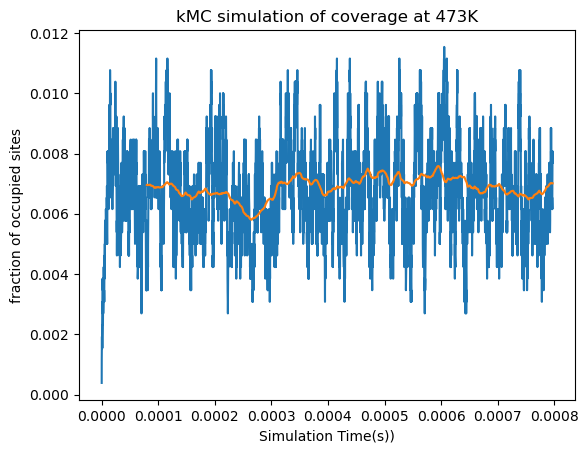

In [83]:
###plot the occupation of sites to see equilibration
fig, ax = plt.subplots()
# Choose a frame skipping factor (e.g., skip every 2 frames)
frame_skip_factor = 2
data = np.sum(my_kmc1.kmc_site_states_history, axis=1)/len(my_kmc1.kmc_site_states)
time_step = np.cumsum(my_kmc1.simulation_time_step_checkpoints)

# Define the frame skipping factor and window size for the moving average
frame_skip_factor = 2  # Skip every 2 frames
window_size = 1000  # Adjust this as needed for the desired smoothing

# Apply the moving average with frame skipping
smoothed_data = np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Create the corresponding time steps for the smoothed data

# Plot the smoothed data
plt.plot(time_step, data,  markersize=5)
plt.plot(time_step[window_size:-window_size], smoothed_data[window_size:-window_size], markersize=5)
plt.xlabel('Simulation Time(s))')
plt.ylabel('fraction of occupied sites')
plt.title('kMC simulation of coverage at {}K'.format(temperature))

# Display or save the plot
plt.savefig(motherdir + '/coverage_{}_{}.png'.format(testname, temperature))


In [84]:
# Saving some results to lammpstrj files
### call from ovito and use color coding modifier for visualization

###first, lets generate a heatmap of the kmc_site_states_history;
###the heatmap is obtained by adding all the kmc_site_states_history, multiplying by the next timestep
timesteps = np.array(my_kmc1.simulation_time_step_checkpoints)
occupation_history = np.array(my_kmc1.kmc_site_states_history)

###due to memory issue, do the matrix multiplication in batches
site_history_after_timestep = np.zeros((len(timesteps)-1, len(newatoms)))
batch_size = 100
for i in range(0, len(timesteps)//batch_size +1):
    ###if i reached the last batch, make the batch size the remaining number of timesteps
    if (i+1)*batch_size >= len(timesteps):
        batch = occupation_history[1+ i*batch_size:]
        timestep_batch = timesteps[i*batch_size:-1]
        site_history_after_timestep[i*batch_size:, :] = np.multiply(batch,timestep_batch.reshape(-1,1))
    else:
        batch = occupation_history[1+ i*batch_size:(i+1)*batch_size+1]
        timestep_batch = timesteps[i*batch_size:(i+1)*batch_size]
        site_history_after_timestep[i*batch_size:(i+1)*batch_size,:] = np.multiply(batch, timestep_batch.reshape(-1,1))


#1. heatmap of the occupation in total simulation
heatmap = np.sum(site_history_after_timestep, axis=0)

with open(motherdir+'/{}_kmc_heatmap_lammpstrj_{}_{}_{}.lammpstrj'.format(testname, temperature,len(timesteps), occupation), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('100000\n')
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(newatoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, newatoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z occupation\n')
    for i in range(len(newatoms)):
        f.write('{} {} {} {} {} {}\n'.format(i+1, newatoms[i].number, 
                                                        newatoms[i].position[0], newatoms[i].position[1], newatoms[i].position[2], heatmap[i]))


#2. heatmap of the occupation after some equilibration time;

heatmap_02_05 = np.average(site_history_after_timestep[int(adsdes_steps*0.5) :int(adsdes_steps)], axis=0)
adsdes_dt = np.sum(timesteps[int(adsdes_steps*0.5) :int(adsdes_steps)])
with open(motherdir+'/{}_kmc_heatmap_adsdes_equil_{}_{}_{}.lammpstrj'.format(testname,temperature,len(timesteps), occupation), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('{}\n'.format(len(site_history_after_timestep)*0.3))
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(newatoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, newatoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z occupation occ_dtnrom\n')
    for i in range(len(newatoms)):
        f.write('{} {} {} {} {} {} {}\n'.format(i+1, newatoms[i].number, 
                                                        newatoms[i].position[0], newatoms[i].position[1], newatoms[i].position[2], 
                                                        heatmap_02_05[i], heatmap_02_05[i]/adsdes_dt))


#3. heatmap of the occupation after some diffusion time;
heatmap_07_10 = np.average(site_history_after_timestep[adsdes_steps + int(diff_steps*0.3) :], axis=0)
diff_dt = np.sum(timesteps[adsdes_steps + int(diff_steps*0.3) :])
with open(motherdir+'/{}_kmc_heatmap_diffusion_equil_{}_{}_{}.lammpstrj'.format(testname,temperature,len(timesteps), occupation), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('{}\n'.format(len(site_history_after_timestep)*0.3))
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(newatoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, newatoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z occupation occ_dtnorm\n')
    for i in range(len(newatoms)):
        f.write('{} {} {} {} {} {} {}\n'.format(i+1, newatoms[i].number, 
                                                        newatoms[i].position[0], newatoms[i].position[1], newatoms[i].position[2], 
                                                        heatmap_07_10[i], np.divide(heatmap_07_10[i],diff_dt)))

#4. heatmap of collision states in total simulation
collisions = np.array(my_kmc1.collision_by_diffusion_site_indices)
###count the collisions on each site
heatmap_collisions = np.zeros((len(newatoms),))
for i in range(len(newatoms)):
    heatmap_collisions[i] = np.sum(collisions == i)
tot_collisions = np.sum(heatmap_collisions)
print('tot_collisions', tot_collisions)
with open(motherdir+'/{}_kmc_collisionmap_lammpstrj_{}_{}_{}.lammpstrj'.format(testname, temperature,len(timesteps), occupation), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('100000\n') ###timesteps dont really matter here
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(newatoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, newatoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z occupation occ_dtnorm\n')
    for i in range(len(newatoms)):
        f.write('{} {} {} {} {} {} {}\n'.format(i+1, newatoms[i].number, 
                                                        newatoms[i].position[0], newatoms[i].position[1], newatoms[i].position[2], 
                                                        heatmap_collisions[i], heatmap_collisions[i]/tot_collisions ))


#5. heatmap of collision states after some diffusion equilibration time; 0.3 to 1.0 of the diffusion steps 
#store normalized values also by the total number of collisions
collsions_after_equil = np.array(my_kmc1.collision_state_history[int(diff_steps*0.3) :])
heatmap_collisions_after_equil = np.zeros((len(newatoms),))
for i in range(len(newatoms)):
    heatmap_collisions_after_equil[i] = np.sum(collsions_after_equil == i)

tot_coll_equil = np.sum(heatmap_collisions_after_equil)
print('tot_coll_equil', tot_coll_equil ,'within ', adsdes_steps+int(diff_steps*0.3), 'dt:', np.sum(timesteps[adsdes_steps+int(diff_steps*0.3):]))
with open(motherdir+'/{}_kmc_collisionmap_equil_lammpstrj_{}_{}_{}.lammpstrj'.format(testname, temperature,len(timesteps), occupation), 'w') as f:
    f.write('ITEM: TIMESTEP\n')
    f.write('100000\n') 
    f.write('ITEM: NUMBER OF ATOMS\n')
    f.write('{}\n'.format(len(newatoms)))
    f.write('ITEM: BOX BOUNDS pp pp pp\n')
    ###write the box bounds from ase atoms object. from 0 to size of cell in direction
    for i in range(3):
        f.write('{} {}\n'.format(0, newatoms.cell[i][i]))
    f.write('ITEM: ATOMS id type x y z occupation occ_dtnorm\n')
    for i in range(len(newatoms)):
        f.write('{} {} {} {} {} {} {}\n'.format(i+1, newatoms[i].number, 
                                                        newatoms[i].position[0], newatoms[i].position[1], newatoms[i].position[2], 
                                                        heatmap_collisions_after_equil[i], heatmap_collisions_after_equil[i]/tot_coll_equil ))
        

###save some information about the simulation
### job specs include adsdes_steps, diff_steps, temperature, coverage, and the number of timesteps
### job specs also include the coverage after equilibration(a scalar), dt of adsdes, dt of diffusion, and the total_simulation_clock
### equilibrated adsdes_dt, equilibrated diff_dt

columns=['motherdir', 'testname', 'randomnumber', 'temperature',
                                  'adsdes_steps', 'diff_steps', 'adsdes_dt', 'diff_dt', 'total_simulation_clock', 'equil_adsdes_dt', 'equil_diff_dt',
                                  'coverage_equil',
                                  'totcoll_after_equil',
                                  'totcoll',
                                  'dt_after_equil_diff',
                                  ]
data =  [motherdir,testname, randomseed, temperature, 
                        adsdes_steps, diff_steps, np.sum(timesteps[:adsdes_steps]), np.sum(timesteps[adsdes_steps:]), np.sum(timesteps), adsdes_dt, diff_dt, 
                        np.average(np.sum(my_kmc1.kmc_site_states_history[int(adsdes_steps*0.5):int(adsdes_steps)], axis=1)/len(my_kmc1.kmc_site_states))*4, 
                        tot_coll_equil,
                        tot_collisions,
                        np.sum(timesteps[adsdes_steps+int(diff_steps*0.3):]),
                        ]

job_specs = pd.DataFrame([data], columns=columns)

job_specs.to_csv(motherdir+'/job_specs_{}_{}_{}.csv'.format(testname, temperature, occupation), index=False)


tot_collisions 33.0
tot_coll_equil 19.0 within  10300 dt: 7.673563475859952e-12


In [111]:
###save the simulation instance as a pickle file. !!!Be aware that the pickle file can be large!!!
import pickle
with open(motherdir+'/{}_kmc_object_{}_{}_{}.pickle'.format(testname,temperature,len(timesteps), occupation), 'wb') as f:
    pickle.dump(my_kmc1, f)